In [2]:
%pylab inline
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import interp1d
from scipy import interpolate

Populating the interactive namespace from numpy and matplotlib


In [3]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.table
import seaborn as sns

In [4]:
plt.rc('font', size=10, family='serif')

## Look at Data

In [4]:
filen = '/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/FiberLocation/files/line_flux_files/complete_line_sum_file.fits'
hdu = fits.open(filen)

In [5]:
data = astropy.table.Table(hdu[1].data)

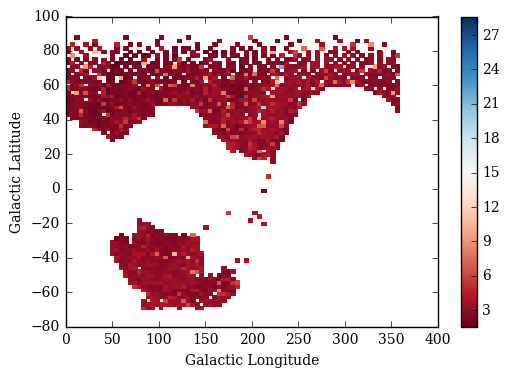

In [11]:
blue_data = data[data['mean_bB']>0]
H, xedges, yedges, binnumber = stats.binned_statistic_2d(blue_data['GAL_LON'], blue_data['GAL_LAT'], blue_data['mean_bB'], statistic = 'mean', bins = 75)
H = np.ma.masked_invalid(H)

XX, YY = np.meshgrid(xedges, yedges)
plt.pcolormesh(XX,YY,H.T,cmap = 'RdBu')
plt.colorbar()
plt.xlabel("Galactic Longitude")
plt.ylabel("Galactic Latitude")

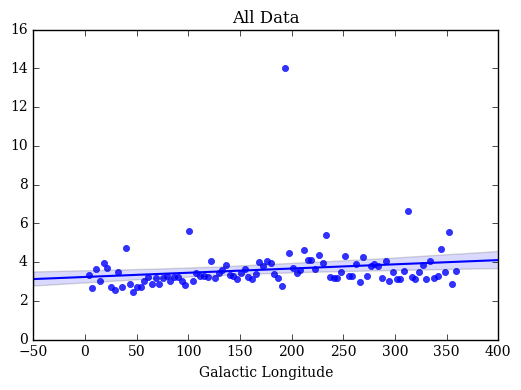

In [13]:
means, edges, bins = stats.binned_statistic(blue_data['GAL_LON'],  blue_data['mean_bB'], statistic = 'mean', bins = 100)
sns.regplot(x = edges[1:], y = means)
plt.xlabel('Galactic Longitude')
plt.title("All Data")

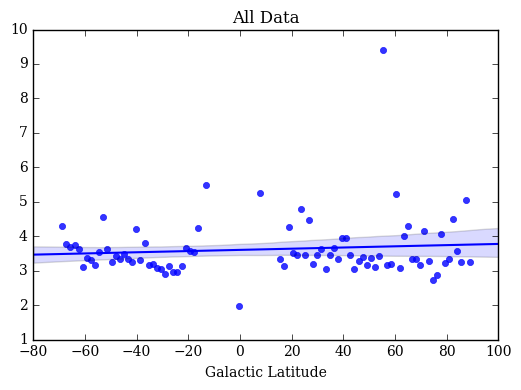

In [14]:
means, edges, bins = stats.binned_statistic(blue_data['GAL_LAT'],  blue_data['mean_bB'], statistic = 'mean', bins = 100)
sns.regplot(x = edges[1:], y = means)
plt.xlabel('Galactic Latitude')
plt.title("All Data")

## Look at Dark data and take out outliers

In [15]:
blue_dark = blue_data[(blue_data['AIRMASS']<1.4) & (blue_data['MOON_ALT']< -18) & (blue_data['SUN_ALT'] < -18) & (blue_data['GAL_LAT'] > 10)]

In [16]:
#outliers explored in zodical notebook
blue_dark = blue_dark[(blue_dark['bB']<2*blue_dark['mean_bB'])&(blue_dark['PLATE']!=7339)] 

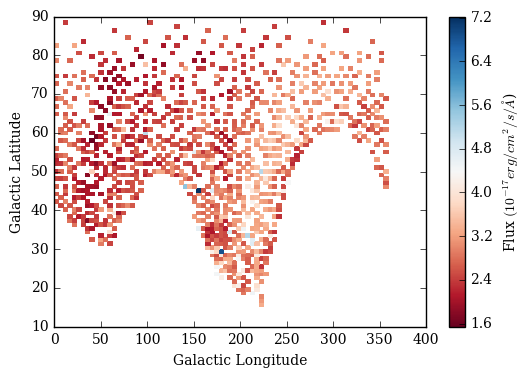

In [19]:
H, xedges, yedges, binnumber = stats.binned_statistic_2d(blue_dark['GAL_LON'], blue_dark['GAL_LAT'], blue_dark['mean_bB'], statistic = 'mean', bins = 75)
H = np.ma.masked_invalid(H)

XX, YY = np.meshgrid(xedges, yedges)
plt.pcolormesh(XX,YY,H.T,cmap = 'RdBu')
clb = plt.colorbar()
plt.xlabel("Galactic Longitude")
plt.ylabel("Galactic Latitude")
clb.set_label("Flux $(10^{-17} erg/cm^{2}/s/\AA$)")

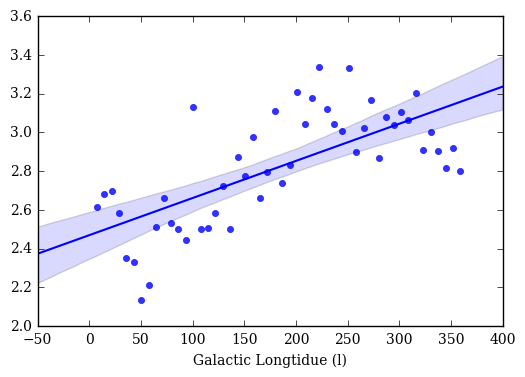

In [20]:
means, edges, bins = stats.binned_statistic(blue_dark['GAL_LON'],  blue_dark['mean_bB'], statistic = 'mean', bins = 50)
sns.regplot(x = edges[1:], y = means)
plt.xlabel("Galactic Longtidue (l)")

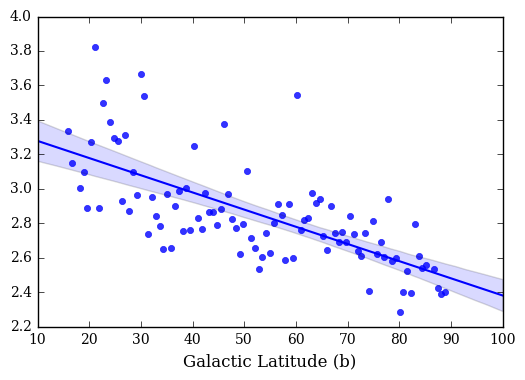

In [21]:
means, edges, bins = stats.binned_statistic(blue_dark['GAL_LAT'],  blue_dark['mean_bB'], statistic = 'mean', bins = 100)
sns.regplot(x = edges[1:], y = means)
plt.xlabel("Galactic Latitude (b)", fontproperties = font)

## Look at Model

In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
sys.path.insert(0,'/Users/parkerf/Research/SkyModel/BOSS_Sky/Model/python/')
from sky_model import SkyModel

In [17]:
Sky = SkyModel()
Sky.run_model()

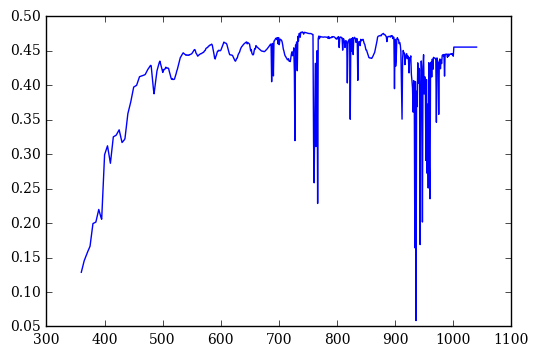

In [213]:
# default ISL spectrum
plt.plot(Sky.Model['wave_range'], Sky.Model['ISL'])

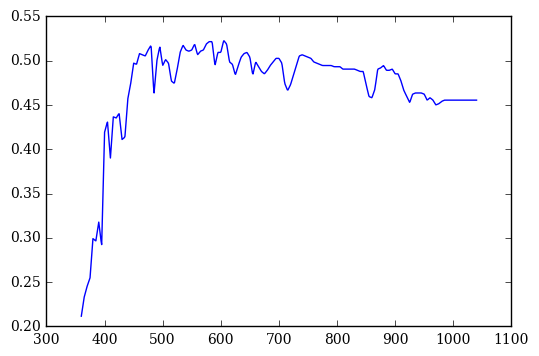

In [214]:
plt.plot(Sky.Model['wave_range'], Sky.I.isl_spectrum)

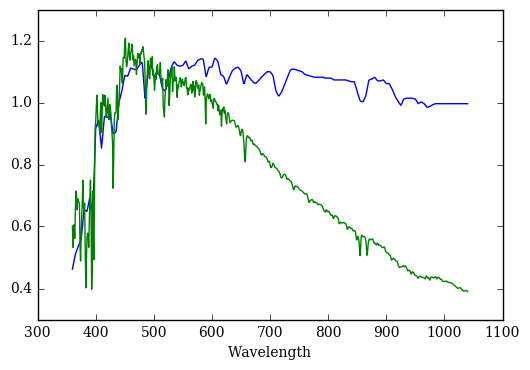

In [235]:
plt.plot(Sky.Model['wave_range'], Sky.I.relative_isl, label = 'relative ISL spectrum')
plt.plot(Sky.Model['wave_range'], Sky.I.rel_sun_isl, label = 'relative solar spectrum')
plt.xlabel("Wavelength")

(0, 360)

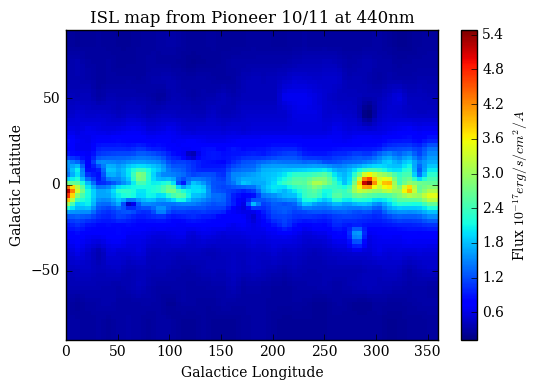

In [232]:
new_lat = np.linspace(-90,90,75)
new_lon = np.linspace(0,360,75)
XX, YY = np.meshgrid(new_lon, new_lat)
plt.pcolormesh(new_lon, new_lat,Sky.I.isl_map(new_lon, new_lat))
plt.xlabel("Galactice Longitude")
plt.ylabel("Galactic Latitude")
clb = plt.colorbar()
clb.set_label("Flux $10^{-17} erg/s/cm^{2}/A$")
plt.title("ISL map from Pioneer 10/11 at 440nm")
plt.ylim(-90,90)
plt.xlim(0,360)

Do melchior calculations

In [131]:
uB = -2.5*np.log10(((7.751e-7)*1.72)*(1/2.9e-8)*(23.5e-12/(4*np.pi)))
uB2 = -2.5*np.log10(((4.518e-6+7.751e-7)*1.72)*(1/2.9e-8)*(23.5e-12/(4*np.pi)))

In [63]:
import speclite.filters
import astropy.units as u

In [95]:
def static_abmag_to_flux(mag,wave):
    """Calcuates flux in 10**-17 erg/s/cm2/A. If the magnitude is quoted per arcsec^2, 
    the BOSS fiber area of pi arcsec^2 is multiplied.
    """
    zero_point = 4260 #Jy

    f_nu = zero_point*(10**(-0.4*mag)) #Jansky
    f_lam = f_nu/(3.34*10**4)*(1/(wave**(2)))
    f_lam = f_lam*10**17 #10^-17 erg/s/cm2/A/arcsec2
    f_lam = f_lam * np.pi #10^-17 erg/s/cm2/A
    print("unit: 10^-17/erg/s/cm2/A")
    return f_lam

In [192]:
melchior_flux = static_abmag_to_flux(uB,4370)
print(melchior_flux)

unit: 10^-17/erg/s/cm2/A
0.180383294759


In [233]:
melchior_flux*(1/np.sin(np.deg2rad(np.abs(Sky.I.GalLat))))

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


array([ 0.183166  ,  0.19195989,  0.20828869,  0.23547367,  0.28062659,
        0.36076659,  0.44348917,  0.52740547,  0.65442253,  0.86759573,
        1.29610746,  2.58590042,         inf,  2.58590042,  1.29610746,
        0.86759573,  0.65442253,  0.52740547,  0.44348917,  0.36076659,
        0.28062659,  0.23547367,  0.20828869,  0.19195989,  0.183166  ])

## Scattering 

### Rayleigh

In [ ]:
n_R = 1.5e25 #cm^-2


In [40]:
wave = Sky.Model['wave_range']
H = 2.788 #km
P = 744 #hPa
def tau_R(wave):
    wave = wave/1000.
    return (744/1013)*(8.6e-3+6.5e-6*2.788)*wave**(-(3.9+0.074*wave+0.05/wave))

In [55]:
def P(zo,zm,Ao,Am):
    C = (3/4)*np.cos(zo)*np.cos(zm)+np.sin(zo)*np.sin(zm)*np.cos(Ao-Am)
    return (1+C**2)

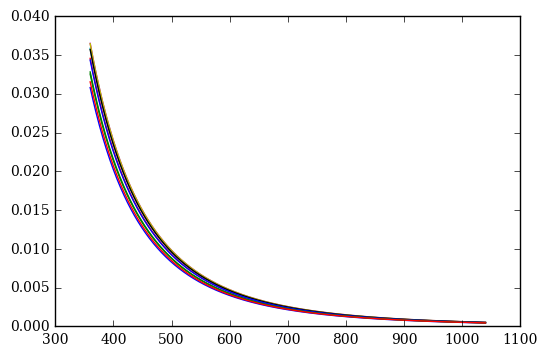

In [57]:
zeniths = [0,10,20,30,40,50,60,70,80,85]
for z in zeniths:
    plt.plot(wave, 7.78e-27*(wave*10/4600)**(-4)/(4*np.pi) * 1.5e25 * P(np.deg2rad(z), np.deg2rad(Sky.ObsMeta['MOON_ZENITH']), np.deg2rad(200),np.deg2rad(250)), label = z)

In [59]:
def Iscatt(wave, zo,zm,Ao,Am):
    Cscatt = 7.78e-27*((wave)/460)**-4
    return Cscatt/(4*np.pi)**np.exp(-tau_R(wave))*P(zo,zm,Ao,Am)*(1+2*tau_R(wave))

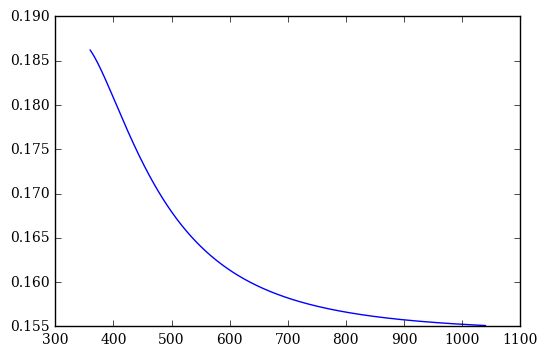

In [60]:
plt.plot(wave, Iscatt(wave, np.deg2rad(Sky.ObsMeta['OBS_ZENITH']), np.deg2rad(Sky.ObsMeta['MOON_ZENITH']), np.deg2rad(200),np.deg2rad(250)))

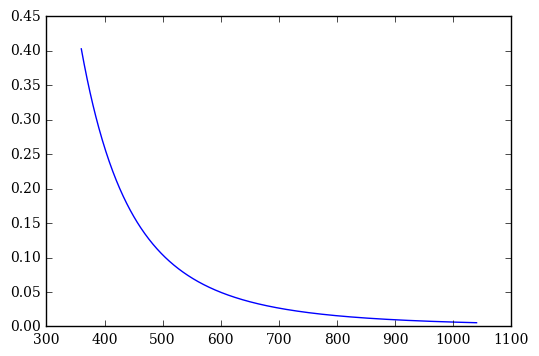

In [58]:
plt.plot(wave, tau_R(wave))